In [9]:
import rasterio
from rasterio.plot import show
with rasterio.open('/Users/kyledorman/Downloads/kelp-sb-dino-test_skysatcollect_visual/SkySatCollect/20240715_221553_ssc8_u0002_visual_clip.tif') as src:
    data = src.read()
data.shape

(4, 7047, 11482)

In [10]:
rgb = data[:3].transpose((1, 2, 0)).copy()
rgb.min(), rgb.max()

(0, 255)

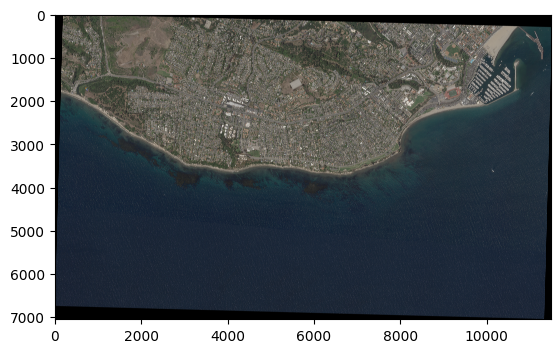

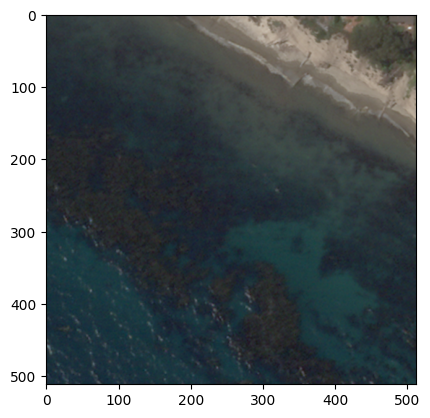

In [11]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(rgb)

plt.figure()
plt.imshow(rgb[3000:3512, 2000:2512])

In [12]:
import cv2
cv2.imwrite("/Users/kyledorman/Desktop/skysat_full.png", rgb)

True

In [23]:
from transformers import pipeline
from transformers.image_utils import load_image

url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/pipeline-cat-chonk.jpeg"
image = load_image(url)

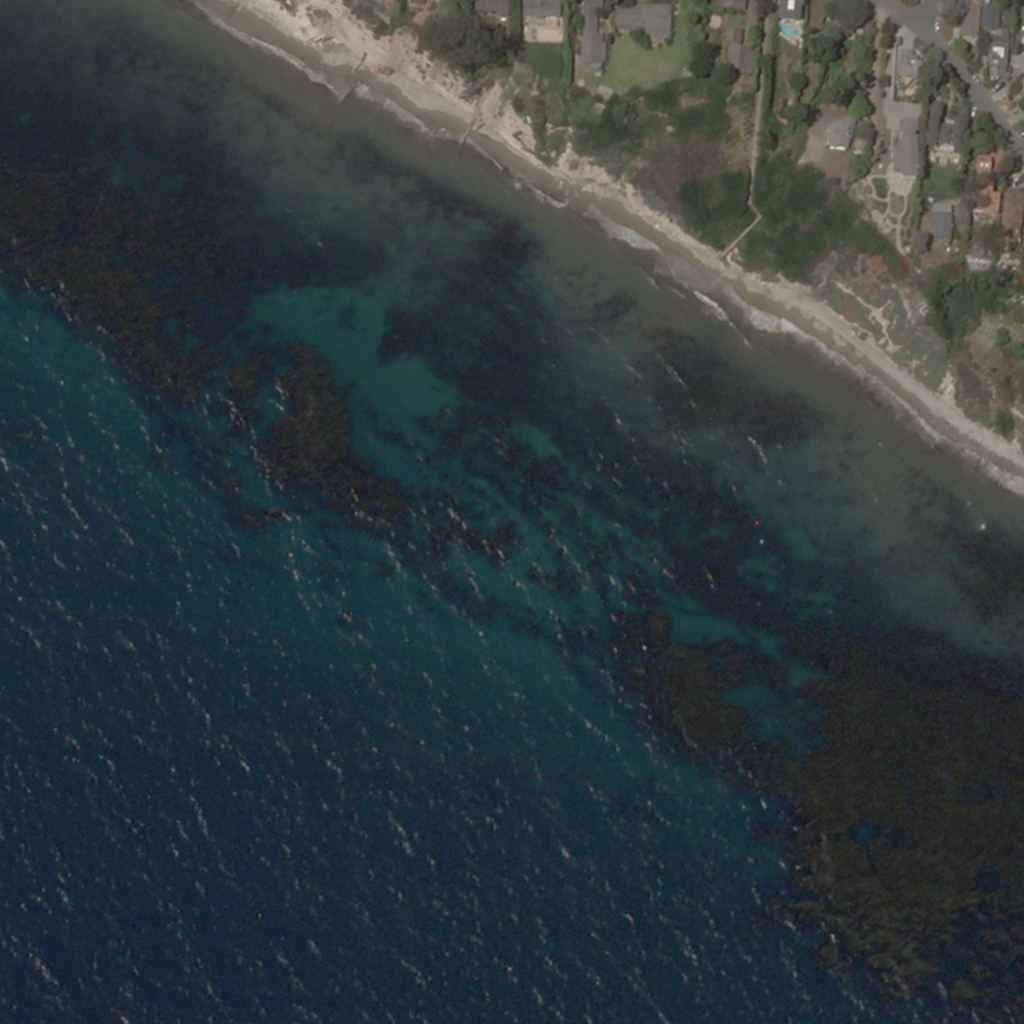

In [74]:
from PIL import Image
end = 3000 + 512 + 512
end2 = 2000 + 512 + 512
img = Image.fromarray(rgb[3000:end, 2000:end2])

img

Using device: cpu


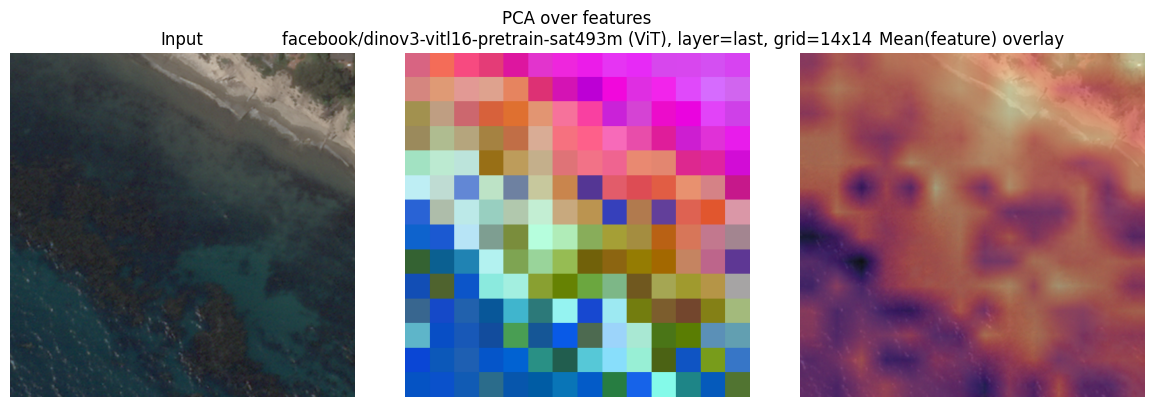

In [40]:
import torch, numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.decomposition import PCA

from transformers import (
    AutoImageProcessor,
    AutoModel,
    DINOv3ViTModel,
    DINOv3ConvNextModel,
)

# ----- utilities -----
def pca_to_rgb(feat: np.ndarray) -> np.ndarray:
    """
    feat: (H, W, C), float32
    returns: (H, W, 3) uint8 RGB
    """
    H, W, C = feat.shape
    X = feat.reshape(-1, C)
    # Center
    X = X - X.mean(0, keepdims=True)
    k = min(3, C)
    comps = PCA(n_components=k, random_state=0).fit_transform(X)  # (H*W, k)
    # Normalize each component to 0..1
    comps -= comps.min(0, keepdims=True)
    denom = comps.max(0, keepdims=True) - comps.min(0, keepdims=True) + 1e-6
    comps = comps / denom
    # If k < 3, pad to 3
    if k < 3:
        comps = np.pad(comps, ((0,0), (0, 3-k)), mode="constant")
    rgb = (comps.reshape(H, W, 3) * 255).astype(np.uint8)
    return rgb

def show_dense(image: Image.Image, feat_hw_c: np.ndarray, title=""):
    """
    image: PIL RGB
    feat_hw_c: (H', W', C)
    Visualize PCA-RGB and mean-channel, both upsampled to image size.
    """
    pca_rgb = pca_to_rgb(feat_hw_c)
    mean_map = feat_hw_c.mean(-1)
    # normalize mean 0..1
    mean_norm = (mean_map - mean_map.min()) / (mean_map.ptp() + 1e-6)

    # Upsample to image size
    pca_img = Image.fromarray(pca_rgb).resize(image.size, Image.NEAREST)
    mean_img = Image.fromarray((mean_norm * 255).astype(np.uint8)).resize(image.size, Image.BILINEAR)

    plt.figure(figsize=(12, 4))
    plt.subplot(1,3,1); plt.imshow(image);   plt.axis("off"); plt.title("Input")
    plt.subplot(1,3,2); plt.imshow(pca_img); plt.axis("off"); plt.title(f"PCA over features\n{title}")
    plt.subplot(1,3,3); plt.imshow(image); plt.imshow(mean_img, cmap="magma", alpha=0.6)
    plt.axis("off"); plt.title("Mean(feature) overlay")
    plt.tight_layout(); plt.show()

# ----- main extractor -----
def visualize_dinov3_dense():
    """
    model_id: e.g. ViT 'facebook/dinov3-vitb16-pretrain-lvd1689m' or ConvNeXt 'facebook/dinov3-convnext-large'
    layer: for ViT, which hidden state to use (0..L). If None, uses last_hidden_state.
           for ConvNeXt, ignored (last_hidden_state is fine).
    """
    dev = "cpu"
    print(f"Using device: {dev}")
    model_id = "facebook/dinov3-vitl16-pretrain-sat493m"
    layer = None

    # Load processor and model (AutoModel will pick the right subclass too)
    processor = AutoImageProcessor.from_pretrained(model_id)
    # If you want to guarantee class, you can branch like below, otherwise AutoModel works for both.
    is_vit = "vit" in model_id.lower()
    if is_vit:
        model = DINOv3ViTModel.from_pretrained(model_id)
    else:
        model = DINOv3ConvNextModel.from_pretrained(model_id)
    model.to(dev).eval()

    batch = processor(img, return_tensors="pt")
    pixel_values = batch["pixel_values"].to(dev)

    with torch.no_grad():
        if is_vit:
            # Ask for hidden states if a specific layer was requested
            out = model(pixel_values, output_hidden_states=layer is not None)
            if layer is None:
                tokens = out.last_hidden_state  # [B, N+special, D]
            else:
                tokens = out.hidden_states[layer]  # same shape
            # Drop cls + optional register tokens, then reshape to grid
            num_reg = getattr(model.config, "num_register_tokens", 0)
            patch_tokens = tokens[:, 1 + num_reg :, :]           # [B, Npatch, D]
            # infer grid side (square)
            N = patch_tokens.shape[1]
            side = int(N ** 0.5)
            feat = patch_tokens[0].reshape(side, side, -1).cpu().float().numpy()
            title = f"{model_id} (ViT), layer={'last' if layer is None else layer}, grid={side}x{side}"
        else:
            out = model(pixel_values)
            # ConvNeXt gives [B, C, H', W']
            fmap = out.last_hidden_state[0].detach().cpu().float().numpy()  # (C, H', W')
            feat = np.moveaxis(fmap, 0, -1)  # (H', W', C)
            Hc, Wc, _ = feat.shape
            title = f"{model_id} (ConvNeXt), feat={Wc}x{Hc}"

    show_dense(img, feat, title=title)

# ---- examples ----
# ViT example (patch tokens → grid)
# visualize_dinov3_dense("your_image.jpg", "facebook/dinov3-vitb16-pretrain-lvd1689m")
# visualize_dinov3_dense("your_image.jpg", "facebook/dinov3-vitl16-pretrain-sat493m", layer=None)

# ConvNeXt example (already dense map)
# visualize_dinov3_dense("your_image.jpg", "facebook/dinov3-convnext-large")

visualize_dinov3_dense()

In [81]:


pipe = pipeline(
    model="facebook/dinov3-vitl16-pretrain-sat493m",
    task="image-feature-extraction", 
)
inputs = pipe.image_processor(
    img, 
    return_tensors="pt",
    size={"shortest_edge": 512},   # try 448, 560, 672...
    do_center_crop=False,
)
inputs = {k: v.to(pipe.model.device, dtype=pipe.model.dtype) for k, v in inputs.items()}

# features = feature_extractor(img)

with torch.no_grad():
    out = pipe.model(**inputs, output_hidden_states=False)  # last_hidden_state is enough
    # out.last_hidden_state: [B, N_tokens, D]
    tokens = out.last_hidden_state


Device set to use mps:0


In [82]:
# Drop class + any register tokens; keep only patch tokens
num_register = getattr(pipe.model.config, "num_register_tokens", 0)
patch_tokens = tokens[:, 1 + num_register :, :]            # [1, Npatch, D]

# Infer patch grid (square)
N = patch_tokens.shape[1]
side = int(N ** 0.5)
feat = patch_tokens[0].reshape(side, side, -1).float().cpu().numpy()  # (H', W', C)

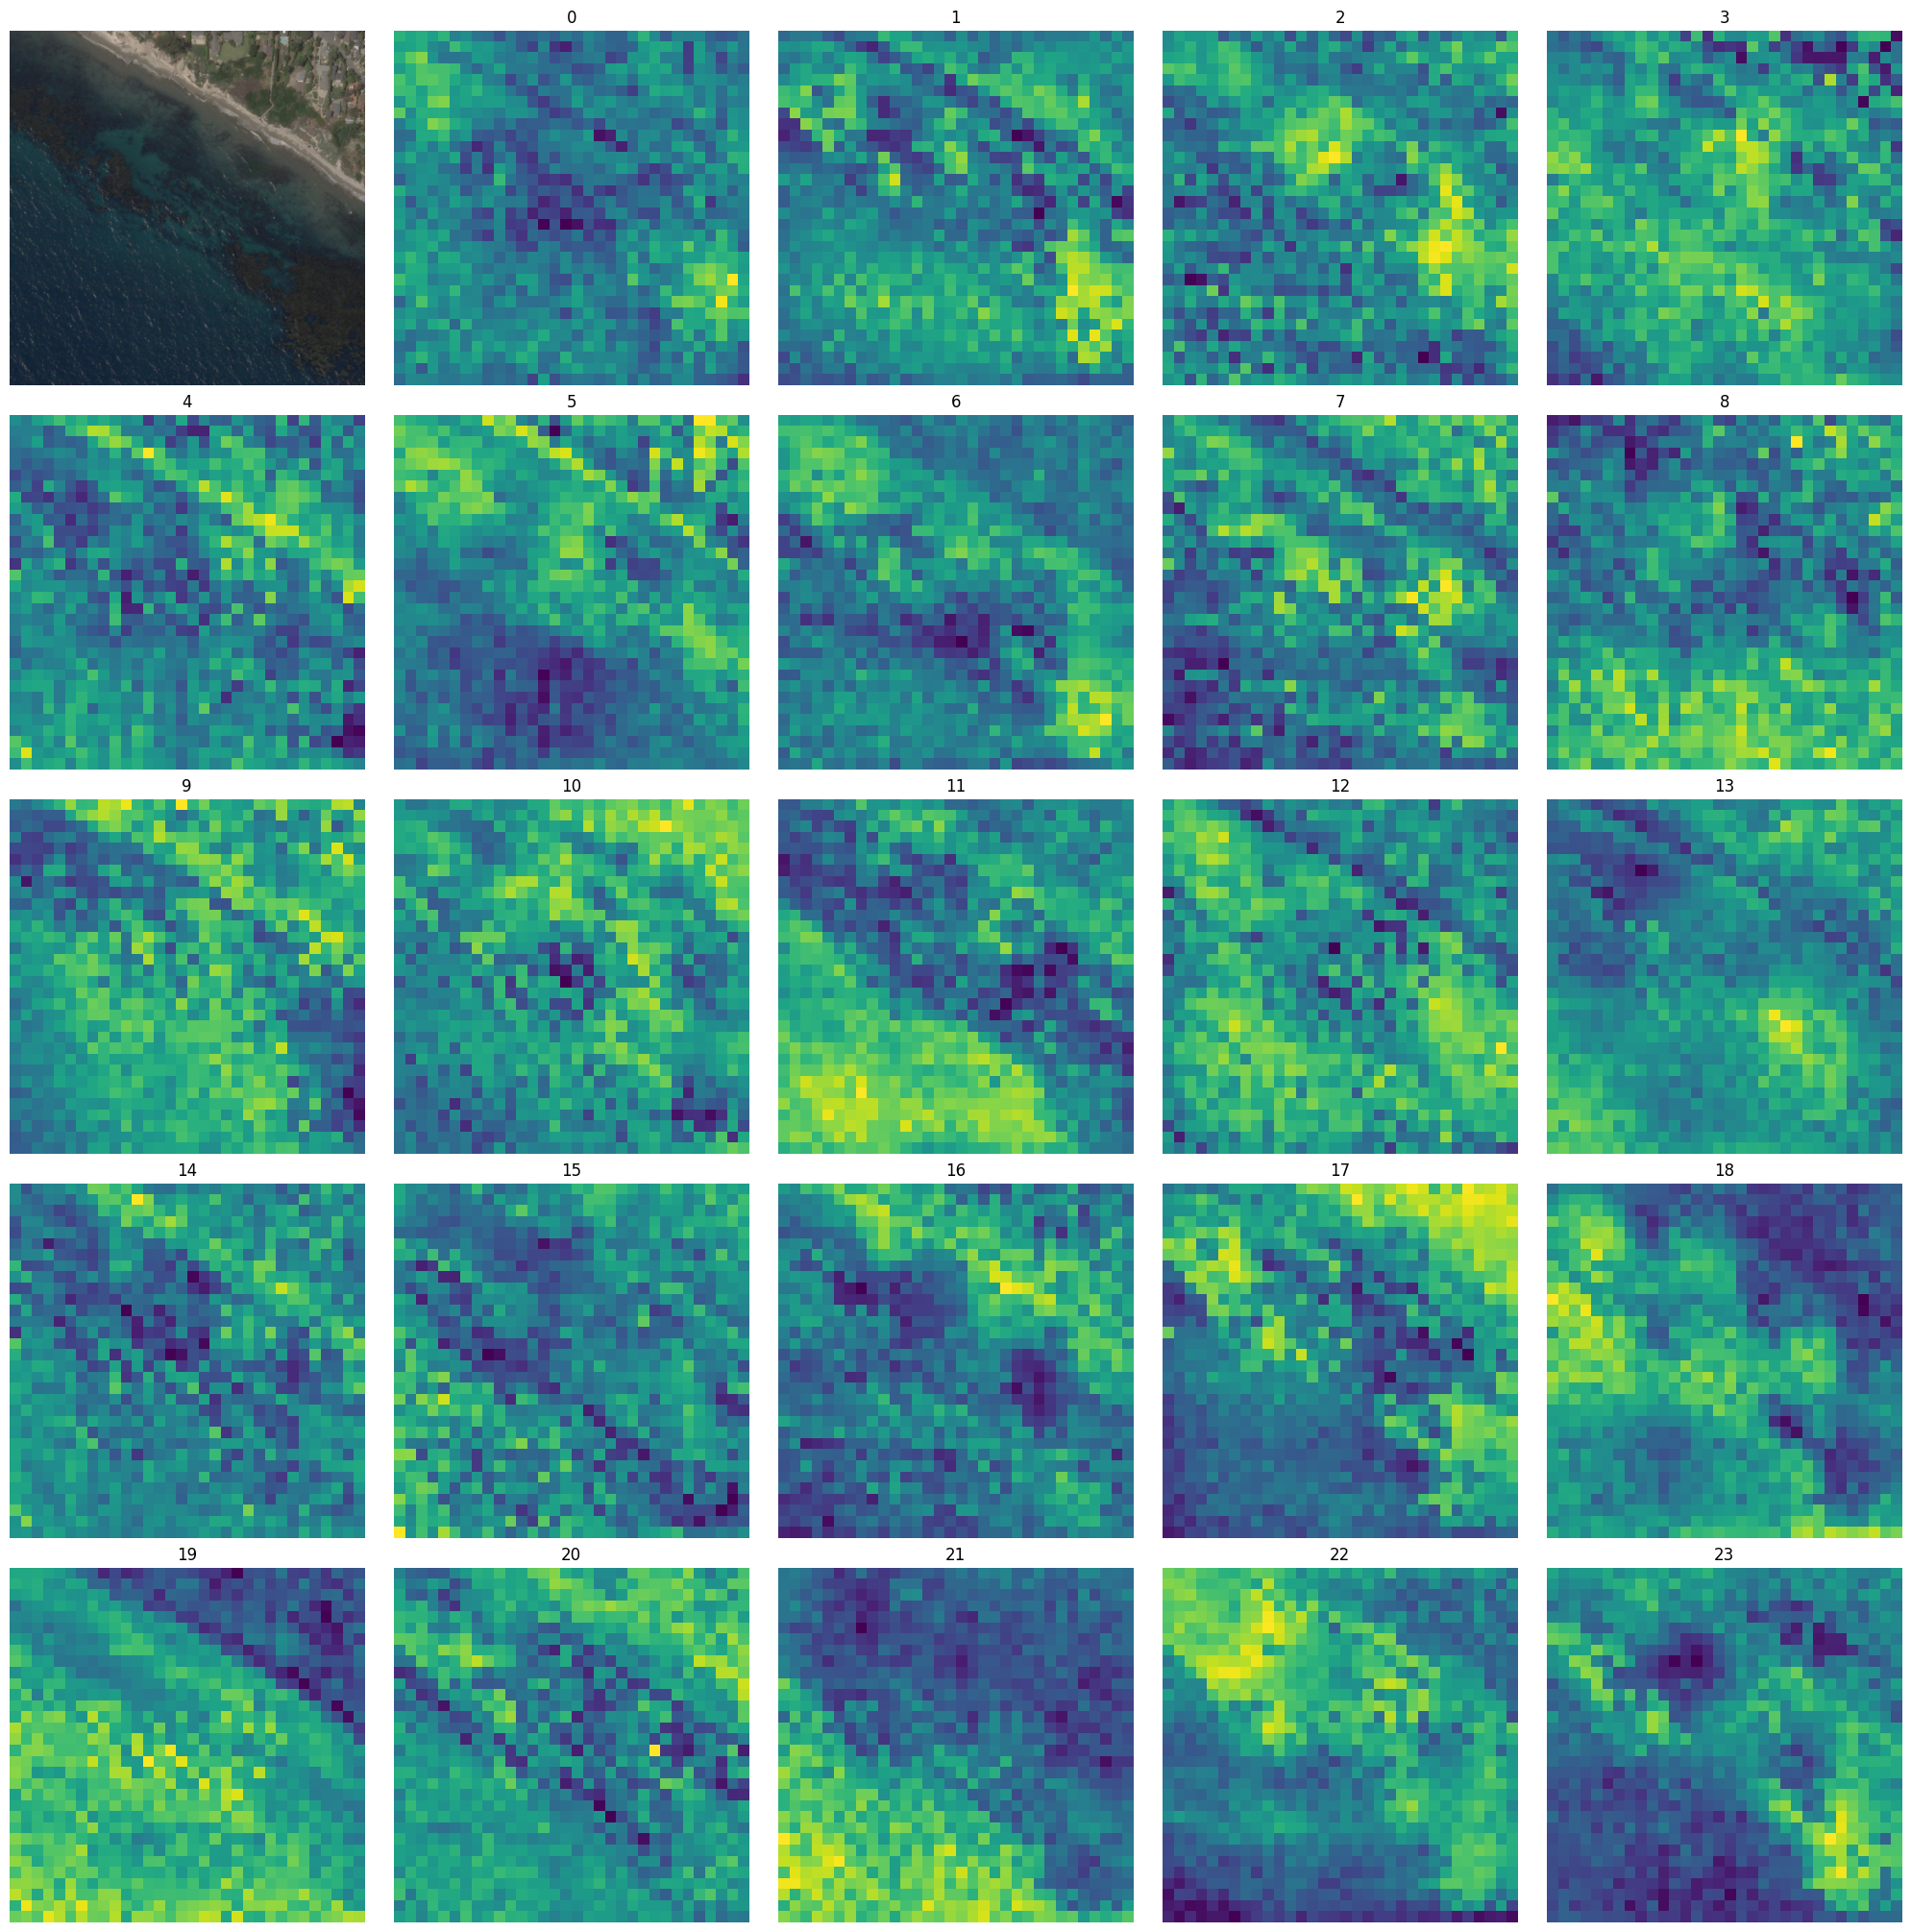

In [83]:
fig, axs = plt.subplots(5, 5, figsize=(20, 20), constrained_layout=True)

# idxes = np.random.choice(unmsk_patch.shape[2], rows * cols - 1, replace=False)

start = 0
end = start + 24
idxes = list(range(start, end))

for idx, ax in zip(idxes, axs.flatten()[1:]):
    ax.imshow(feat[:, :, idx])
    ax.set_axis_off()
    ax.set_title(idx)

ax = axs.flatten()[0]
ax.imshow(img)
ax.set_axis_off()

plt.show()

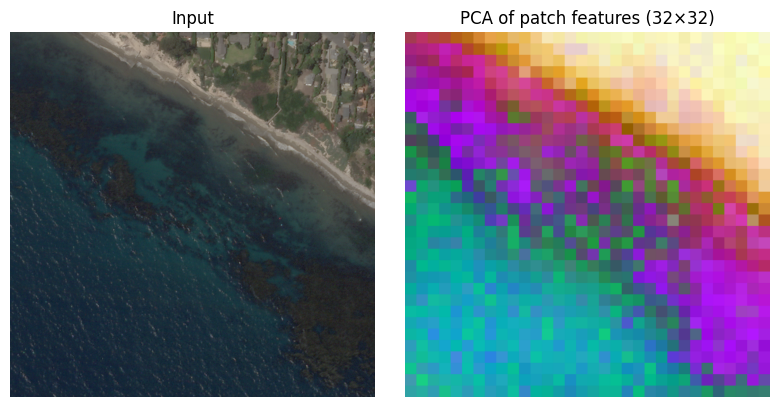

In [85]:
import numpy as np
from sklearn.decomposition import PCA

# --- visualize dense features with PCA → RGB + mean overlay ---
def pca_to_rgb(feat_hw_c: np.ndarray) -> np.ndarray:
    H, W, C = feat_hw_c.shape
    X = feat_hw_c.reshape(-1, C)
    X = X - X.mean(0, keepdims=True)
    k = min(3, C)
    comps = PCA(n_components=k, random_state=0).fit_transform(X)
    comps -= comps.min(0, keepdims=True)
    comps /= (comps.max(0, keepdims=True) - comps.min(0, keepdims=True) + 1e-6)
    if k < 3:
        comps = np.pad(comps, ((0,0), (0, 3-k)))
    return (comps.reshape(H, W, 3) * 255).astype(np.uint8)

pca_rgb = pca_to_rgb(feat)
mean_map = feat.mean(-1)
mean_norm = (mean_map - mean_map.min()) / (mean_map.ptp() + 1e-6)

pca_img  = Image.fromarray(pca_rgb).resize(img.size, Image.NEAREST)
mean_img = Image.fromarray((mean_norm * 255).astype(np.uint8)).resize(img.size, Image.BILINEAR)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(img); plt.axis("off"); plt.title("Input")
plt.subplot(1,3,2); plt.imshow(pca_img); plt.axis("off"); plt.title(f"PCA of patch features ({side}×{side})")
# plt.subplot(1,3,3); plt.imshow(img); plt.imshow(mean_img, cmap="magma", alpha=0.6); plt.axis("off"); plt.title("Mean(feature) overlay")
plt.tight_layout(); 
plt.savefig("/Users/kyledorman/Desktop/dinov3.png")
plt.show()

In [ ]:
import yaml
import torch
from claymodel.module import ClayMAEModule
import numpy as np
from pathlib import Path
import datetime
from matplotlib import pyplot as plt
from pyproj import Transformer
import rasterio
from rasterio.plot import show
import copy
from torchvision.transforms import v2
import math
from estuary.util import contrast_stretch
from einops import rearrange
from sklearn import decomposition, svm
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_recall_fscore_support, f1_score, balanced_accuracy_score
from estuary.clay.data import EstuaryDataModule
from estuary.clay.module import EstuaryModule
import tqdm

In [ ]:
# Load model
model = ClayMAEModule.load_from_checkpoint(
    "/Users/kyledorman/data/models/clay/clay-v1.5.ckpt",
    metadata_path="/Users/kyledorman/data/models/clay/metadata.yaml",
    mask_ratio=0.0,
    shuffle=False,
)
_ = model.eval()

In [ ]:
# Load sensor metadata
with open("/Users/kyledorman/data/models/clay/metadata.yaml", "r") as f:
    metadata = yaml.safe_load(f)

channel_4_band_order = [
    'blue',
    'green',
    'red',
    'nir',
]
planetscope = metadata['planetscope-sr']
metadata['planetscope-sr-4'] = {}
metadata['planetscope-sr-4']['band_order'] = channel_4_band_order
metadata['planetscope-sr-4']['rgb_indices'] = [3, 2, 1]
metadata['planetscope-sr-4']['gsd'] = 3
bands = {}
for k, vs in planetscope['bands'].items():
    vs4 = {kk: vv for kk, vv in vs.items() if kk in channel_4_band_order}
    bands[k] = vs4
metadata['planetscope-sr-4']['bands'] = bands

metadata['planetscope-sr-4']

In [ ]:
def normalize_latlon(lat, lon):
    """
    Normalize latitude and longitude to a range between -1 and 1.

    Parameters:
    lat (float): Latitude value.
    lon (float): Longitude value.

    Returns:
    tuple: Normalized latitude and longitude values.
    """
    lat = lat * np.pi / 180
    lon = lon * np.pi / 180

    return (math.sin(lat), math.cos(lat)), (math.sin(lon), math.cos(lon))

def normalize_timestamp(date):
    week = date.isocalendar().week * 2 * np.pi / 52
    hour = date.hour * 2 * np.pi / 24

    return (math.sin(week), math.cos(week)), (math.sin(hour), math.cos(hour))

def prep_datacube(image, lat, lon, date):
    """
    Prepare a data cube for model input.

    Parameters:
    image (np.array): The input image array.
    lat (float): Latitude value for the location.
    lon (float): Longitude value for the location.

    Returns:
    dict: Prepared data cube with normalized values and embeddings.
    """
    md = metadata['planetscope-sr-4']

    # Extract mean, std, and wavelengths from metadata
    mean = []
    std = []
    waves = []
    bands = md['band_order']
    for band_name in bands:
        mean.append(md['bands']['mean'][band_name])
        std.append(md['bands']['std'][band_name])
        waves.append(md['bands']['wavelength'][band_name] * 1000)

    transform = v2.Compose(
        [
            v2.Resize(size=(128, 128), interpolation=3),
            v2.Normalize(mean=mean, std=std),
        ]
    )

    # Prep datetimes embedding
    times = normalize_timestamp(date)
    week_norm = times[0]
    hour_norm = times[1]

    # Prep lat/lon embedding
    latlons = normalize_latlon(lat, lon)
    lat_norm = latlons[0]
    lon_norm = latlons[1]

    # Prep pixels
    pixels = torch.from_numpy(image.astype(np.float32))
    pixels = transform(pixels)
    pixels = pixels.unsqueeze(0)

    # Prepare additional information
    return {
        "pixels": pixels,
        "time": torch.tensor(
            np.hstack((week_norm, hour_norm)),
            dtype=torch.float32,
        ).unsqueeze(0),
        "latlon": torch.tensor(
            np.hstack((lat_norm, lon_norm)), dtype=torch.float32
        ).unsqueeze(0),
        "waves": torch.tensor(waves),
        "gsd": torch.tensor(md['gsd'] * 2).unsqueeze(0),
    }

In [ ]:
datacube = prep_datacube(data, *cent_g, dt)
with torch.no_grad():
    unmsk_patch, unmsk_idx, msk_idx, msk_matrix = model.model.encoder(datacube)

In [ ]:
# The first embedding is the class token, which is the overall single embedding.
unmsk_patch[:, 0, :].cpu().numpy()

In [ ]:
ep_embedder_cpu = torch.export.load("/Users/kyledorman/data/models/clay/clay-v1.5-encoder_256.pt2").module()

In [ ]:
%%time
datacube = prep_datacube(data, *cent_g, dt)
with torch.no_grad():
    embeddings = ep_embedder_cpu(datacube)
datacube["pixels"].shape, embeddings.shape

In [ ]:
size = 32

embed = rearrange(
    unmsk_patch[:, 1:, :].detach().cpu().numpy(), "b (h w) d-> b d h w", h=size, w=size
)
embed = embed[0]
rows = 4
cols = 4
fig, axs = plt.subplots(cols, cols, figsize=(20, 20))

# idxes = np.random.choice(unmsk_patch.shape[2], rows * cols - 1, replace=False)

for idx, ax in zip(idxes, axs.flatten()[1:]):
    ax.imshow(embed[idx], cmap="bwr")
    ax.set_axis_off()
    ax.set_title(idx)

ax = axs.flatten()[0]
dd = np.log10(1 + data[[3, 2, 1]].clip(1, 2000))
dd = contrast_stretch(dd)
show(dd, ax=ax)
ax.set_axis_off()
ax.set_title(idx)

plt.tight_layout()

In [ ]:
labels = pd.read_csv("/Users/kyledorman/data/estuary/label_studio/00025/labels.csv")
labels

In [ ]:
module = EstuaryModule.load_from_checkpoint(
    "/Users/kyledorman/data/results/estuary/train/20250805-205230/checkpoints/epoch=33-step=5032.ckpt", 
    strict=False)
module.conf.holdout_region = None
module = module.eval()

In [ ]:
dm = EstuaryDataModule(module.conf)
dm.prepare_data()
dm.setup()

In [ ]:
dl = dm.train_dataloader()

preds = []
labels = []
for batch, blabel in tqdm.tqdm(dl, total=len(dl)):
    for k in batch.keys():
        batch[k] = batch[k].to(module.device)
    pred_batch = module.forward(batch)
    preds.extend(pred_batch.argmax(axis=1).detach().cpu().numpy().tolist())
    labels.extend(blabel.detach().cpu().numpy().tolist())

accuracy_score(labels, preds)

In [ ]:
dl = dm.val_dataloader()

preds = []
labels = []
for batch, blabel in tqdm.tqdm(dl, total=len(dl)):
    for k in batch.keys():
        batch[k] = batch[k].to(module.device)
    pred_batch = module.forward(batch)
    preds.extend(pred_batch.argmax(axis=1).detach().cpu().numpy().tolist())
    labels.extend(blabel.detach().cpu().numpy().tolist())

accuracy_score(labels, preds)

In [ ]:
dl = dm.test_dataloader()

preds = []
labels = []
for batch, blabel in tqdm.tqdm(dl, total=len(dl)):
    for k in batch.keys():
        batch[k] = batch[k].to(module.device)
    pred_batch = module.forward(batch)
    preds.extend(pred_batch.argmax(axis=1).detach().cpu().numpy().tolist())
    labels.extend(blabel.detach().cpu().numpy().tolist())

accuracy_score(labels, preds)

In [ ]:
label_df = dm.test_ds.df
X_test = []
for _, row in label_df.iterrows():
    pth = Path(row.source_jpeg)
    emb_pth = pth.parent.parent / "embeddings" / f"{pth.stem}.npy"
    emb = np.load(emb_pth)
    X_test.append(emb)
X_test = np.array(X_test)
y_test = np.array(label_df.label_idx.tolist())

label_df = dm.train_ds.df
X_train = []
for _, row in label_df.iterrows():
    pth = Path(row.source_jpeg)
    emb_pth = pth.parent.parent / "embeddings" / f"{pth.stem}.npy"
    emb = np.load(emb_pth)
    X_train.append(emb)
X_train = np.array(X_train)
y_train = np.array(label_df.label_idx.tolist())

In [ ]:
clf = svm.SVC()
# clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Predict classes on test set
svn_pred = clf.predict(X_test)
y_test = dm.test_ds.df.label_idx
# Perfect match for SVM
match = np.sum(y_test == svn_pred)
print(f"Matched {match} out of {len(X_test)} correctly")

_ = ConfusionMatrixDisplay.from_predictions(
    y_test, 
    svn_pred, 
    labels=list(range(len(["open", "closed"]))),
    display_labels=["open", "closed"],
)

print("Accuracy", accuracy_score(y_test, svn_pred))
prfs = precision_recall_fscore_support(y_test, svn_pred, average='macro')
print("F1", round(prfs[2], 3))
print("Precision", round(prfs[0], 3))
print("Recall", round(prfs[1], 3))

In [ ]:
pred_df.label.sum(), pred_df.dnn.sum()

In [ ]:
pred_df

In [ ]:
pred_df = pd.DataFrame(
    list(zip(
        preds,
        svn_pred,
        dm.test_ds.df.label_idx.tolist(),
        dm.test_ds.df.region.tolist(),
        dm.test_ds.df.source_jpeg.tolist(),
    )), 
    columns=['dnn', 'svn', 'label', 'region', 'source_jpeg']
)
# Define a function to compute accuracy per group
def compute_accuracy(group, pred_col):
    return balanced_accuracy_score(group['label'], group[pred_col])

# Group by region and compute accuracy
dnn_acc_by_region = pred_df.groupby('region').apply(lambda g: compute_accuracy(g, 'dnn'))
svn_acc_by_region = pred_df.groupby('region').apply(lambda g: compute_accuracy(g, 'svn'))
closed_pct = pred_df.groupby('region').apply(lambda g: g.label.sum() / g.label.count())

# Combine into a DataFrame for display
acc_df = pd.DataFrame({
    'dnn': dnn_acc_by_region,
    'svn': svn_acc_by_region,
    "closed_pct": closed_pct,
}).reset_index()

# Show the result
print(acc_df.round(3))

print("dnn", balanced_accuracy_score(pred_df.label, pred_df.dnn))
print("svn", balanced_accuracy_score(pred_df.label, pred_df.svn))

In [ ]:
labels = pd.read_csv("/Users/kyledorman/data/estuary/label_studio/00025/labels.csv")
for r, g in labels.groupby("region"):
    print(r, round((g.label == "closed").sum() / len(g.label), 3))

In [ ]:
from PIL import Image
aaa = pred_df[(pred_df.dnn != pred_df.label)]

rows = 3
cols = 4
fig, axs = plt.subplots(cols, cols, figsize=(15, 15))

for (idx, row), ax in zip(aaa.iterrows(), axs.flatten()):
    ax.imshow(Image.open(row.source_jpeg))
    ax.set_axis_off()
    ax.set_title(f"{row.region} pred={module.conf.classes[row.dnn]} label={module.conf.classes[row.label]}")

plt.tight_layout()

In [ ]:
dm = 